# Basic Library Generation

Now that we have a basic understanding of how to use Synthesizer to create a galaxy object, we can move on to generating a library of galaxies. This is done using the `GalaxyBasis` class, which takes a set of parameters and generates a library of galaxies based on those parameters.

In the most simple use-case, we define outside of the GalaxyBasis object the parameter space we want to sample, and then define the `GalaxyBasis` object with these arrays. We provide a helper function to generate these arrays for us, but you have complete freedom to define more complex parameter spaces if you wish.

## Drawing Samples

In [1]:
from matplotlib import pyplot as plt

from synference import GalaxyBasis

These arrays can be generated using the `draw_from_hypercube` function, which takes as input the number of samples you want to draw, and the ranges for each parameter. The ranges are defined as a dictionary of tuples, where they key is the parameter range and each tuple contains the minimum and maximum value for that parameter. The function will then return a dictionary of arrays, where each array contains the values for that parameter.

The `draw_from_hypercube` function by default uses a form of low-discrepancy sampling called Latin Hypercube Sampling (LHS), which is a more efficient way of sampling a multi-dimensional space than random sampling. This is particularly useful when the number of parameters is large, as it ensures that the parameter space is sampled more evenly.

The dictionary we must define will encapsulate our prior knowledge of the parameter space we wish to sample. For this example, we will define a parameter space with two parameters: redshift and log_stellar_mass. The default option is uniform sampling between the upper and lower bounds provided, but you can draw from any distribution you like by defining the arrays yourself.


In [2]:
from synference import draw_from_hypercube

param_ranges = {"redshift": (0.0, 5.0), "log_stellar_mass": (8.0, 12.0)}

Above we have defined a parameter space with two parameters: redshift and log_stellar_mass. We have defined the ranges for these parameters as (0.0, 5.0) and (8.0, 12.0) respectively. We then use the `draw_from_hypercube` function to draw 100 samples from this parameter space, which returns a dictionary of arrays containing the values for each parameter.

In [3]:
param_grid = draw_from_hypercube(param_ranges, 20, rng=42)

If we plot these values, we can see that the parameter space is sampled more evenly than if we had used random sampling.

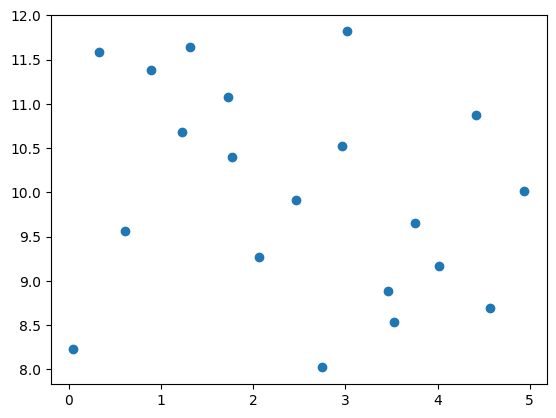

In [4]:
plt.scatter(param_grid["redshift"], param_grid["log_stellar_mass"])

For our basic model for this tutorial we will define a 6 dimensional parameter space, with the following parameters:
 - redshift - the redshift of the galaxy
 - log_stellar_mass - the logarithm (base 10) of the stellar mass in solar masses
 - log_zmet - the logarithm (base 10) of the stellar metallicity
 - peak_age - the age of the peak of the log-normal SFH
 - tau - the width of the log-normal SFH
 - tau_v - V-band optical depth

We will draw 10,000 samples from this parameter space, and use these to generate a library of galaxies. This isn't a large enough sample size for a useful library, but it will run quickly for this demonstration.

In [17]:
param_dict = {
    "redshift": (0, 5),
    "log_stellar_mass": (8, 12),
    "log_zmet": (-4.0, -1.4),
    "peak_age_norm": (0.0, 0.99),  # fraction of the age of the universe
    "tau": (0.1, 2.0),  # dex
    "tau_v": (0.0, 3.0),  # magnitudes
}

params = draw_from_hypercube(param_dict, 1e4, rng=42)

## Generating SFH Distributions

In the previous tutorial we saw how to generate a single `SFH` class instance representing a `Constant` star formation history. However, in many cases we may want to generate a library of star formation histories that represent a range of different galaxy types. Whilst this can be done entirely manually, synference provides a convenient helper function to generate a library of star formation histories based on a set of parameters.

In [6]:
from synthesizer.parametric import SFH
from unyt import Myr

from synference import generate_sfh_basis

The way the `generate_sfh_basis` function works is that we give it the desired SFH class (e.g. `SFH.LogNormal`), and then provide it with the parameters required to instantiate that class. The function will then return an array of `SFH` instances, each with the parameters drawn from the arrays we provide. We also provide parameter units as unyt Units, which ensures that the parameters are correctly interpreted by the `SFH` class. 

Optionally we can define a redshift dependent star formation history, and provide a parameter which will be scaled by the available lookback time at the redshift of the galaxy. This is useful for parameters which are physically constrained by the age of the universe, such as the peak age of a log-normal SFH. 

In [20]:
sfh_models, _ = generate_sfh_basis(
    sfh_type=SFH.LogNormal,
    sfh_param_names=["peak_age_norm", "tau"],
    sfh_param_arrays=[params["peak_age_norm"], params["tau"]],
    sfh_param_units=[None, None],
    redshifts=params["redshift"],
)

print(len(sfh_models), type(sfh_models[0]))

Creating SFHs: 10000it [00:00, 30666.48it/s]

10000 <class 'synthesizer.parametric.sf_hist.LogNormal'>


We can see that the `generate_sfh_basis` function has returned an array of 1000 `SFH.LogNormal` instances, each with the parameters drawn from the arrays we provided.

## Generating Metallicity Distributions

In the same manner that we can generate a library of star formation histories, we can also generate a library of metallicity histories. These are simpler to generate, so we don't provide a helper function for this, but it is still straightforward to do manually. 

In [8]:
from synthesizer.parametric import ZDist

zdists = []

for z in params["log_zmet"]:
    zdists.append(ZDist.DeltaConstant(log10metallicity=z))

print(len(zdists), zdists[0])

10000 ----------
SUMMARY OF PARAMETERISED METAL ENRICHMENT HISTORY
<class 'synthesizer.parametric.metal_dist.DeltaConstant'>
metallicity: None
log10metallicity: -3.5675878524780273
----------



All the above code does is loop over the metallicities drawn from the prior samples, and generate a metallicity class instance for each, and append it to a list.

## Setting up the rest of our Synthesizer model

### Grid

We must load in the SPS grid we will use to generate our stellar and nebular spectra. As we will be generating a lot of spectra, we may also wish to set the wavelength array defined for the grid, to limit the resolution and min/max limits to save storage space and processing time. This can be set on creating a `Grid` by passing a `new_lam` argument with a new wavelength array, onto which the grid will be interpolated using a flux-conserving interpolation. We have a helper method to generate a new wavelength array with constant R between two wavelengths.

Here we are using a BPASS SPS grid with a Chabrier 2003 IMF, which has been post-processed with Cloudy 23.01.

In [9]:
from synthesizer.grid import Grid
from unyt import Angstrom

from synference import generate_constant_R

new_lam = generate_constant_R(R=300, start=1 * Angstrom, stop=50_000 * Angstrom)

grid = Grid("test_grid", new_lam=new_lam)


### Emission Models

If you've already read the previous tutorial, you'll remember that emission models are crucial for defining the process by which we generate observables of our galaxies. The `GalaxyBasis` class takes a single `EmissionModel` instance which is used for all galaxy generation.

In this example, as we have defined our model with a dust component (`tau_v`), we will use a `TotalEmission` emission model.

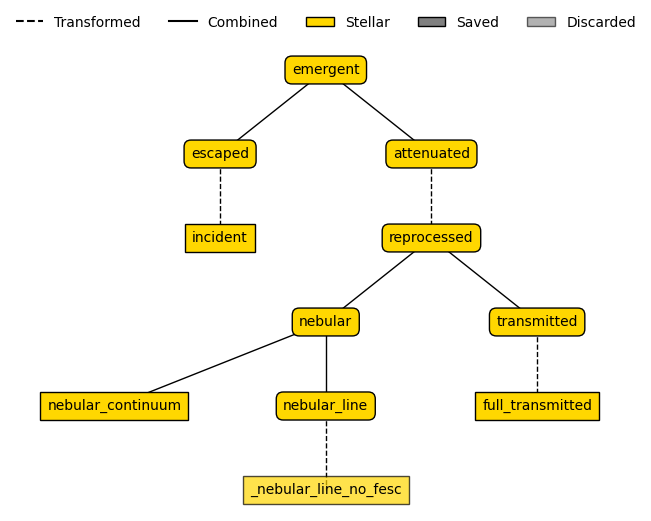

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [10]:
from synthesizer.emission_models import TotalEmission
from synthesizer.emission_models.attenuation import PowerLaw

emission_model = TotalEmission(
    grid=grid,
    dust_curve=PowerLaw(slope=-0.7),
)

emission_model.plot_emission_tree()

You'll notice that above, unlike in the first tutorial, we didn't set the optical depth `tau_v` directy on the emission model. This is because we want it to vary between galaxies, so we will instead pass this attrivute to `GalaxyBasis` to set it on the individual `Galaxy` level.

## Instruments and Filters

Finally, the last thing we have to define is what we actually want to observe. By default we would just get the rest-frame and observed-frame spectra on the wavelengths of the `Grid`, but what if we want observations in specific photometric filters, or matched to the resolution of a specfic spectroscopic instrument? We must create and define an `Instrument`, which contains this information.

Here we will load a predefined NIRCam instrument containing the wideband photometric filters.

In [11]:
from synthesizer.instruments import JWSTNIRCamWide

instrument = JWSTNIRCamWide()

## Putting it all together - Generating our Library

Now that we have all the constituent components of our model we can finally put it all together and generate our library of observables. Firstly we simply instantiate a `GalaxyBasis` object, passing in the various components we have created above.

We also have to set a `galaxy_params` dictionary, which contains any arguments we wish to set on the individual galaxies. In this case, it is just the optical depth `tau_v`, but there could be a lot of emission model parameters which are set on individual galaxy, star or black hole instances. We are also explicitly telling the code to ignore the 'max_age' parameter, which will vary between galaxies but is simply a defined transformation of the redshift, and is hence a redundant parameter.

We give this model a name, 'testing_model', which will be used when saving the output files.

In [21]:
galaxy_params = {"tau_v": params["tau_v"]}

galaxy_basis = GalaxyBasis(
    grid=grid,
    model_name="testing_model",
    redshifts=params["redshift"],
    emission_model=emission_model,
    instrument=instrument,
    sfhs=sfh_models,
    metal_dists=zdists,
    log_stellar_masses=params["log_stellar_mass"],
    galaxy_params=galaxy_params,
    params_to_ignore=["max_age"],
)

2025-11-03 18:00:55,394 | synference | INFO     | Generating grid directly from provided parameter samples.


Now that we have created an instance of the `GalaxyBasis`, we can run the grid creation using the `create_mock_cat` method. Here we set the output model name, which emission model key to generate the grid from (by default 'total'), as well as setting optional configuration parameters. We can see for our above emisison model that the root key is 'emergent', so we will set that here. We couldalso change the output folder - it will default to the internal grids/ folder where the synference code is installed.

The `create_mock_cat` method uses the Synthesizer packages `Pipeline` functionality, which batches the galaxies and allows parallel execution if Synthesizer has been installed with OpenMP support (see the Synthesizer installaion documentaiton for more information.) This speeds up galaxy creation, and allows batching across nodes and cores on a HPC for generating very large libraries.

We also save the parameter transforms the 'max_age' parameter, which is a derived parameter based on the redshift of the galaxy. This is useful for later analysis so we can easily reconstruct the original parameter space.

In [13]:
def max_age(x):
    """Compute the maximum age of the universe at a given redshift."""
    from astropy.cosmology import Planck18 as cosmo
    from unyt import Myr

    return cosmo.age(x["redshift"]).to_value("Myr") * Myr


param_transforms = {"max_age": ("max_age", max_age)}

In [23]:
galaxy_basis.create_mock_cat(
    "test_model_grid",
    emission_model_key="emergent",
    overwrite=True,
    parameter_transforms_to_save=param_transforms,
    n_proc=1,
)

2025-11-03 18:02:06,676 | synference | INFO     | Checking parameters inside create_matched_galaxies.
2025-11-03 18:02:06,680 | synference | INFO     | 10000


Creating galaxies: 100%|██████████| 1/1 [00:43<00:00, 43.94s/it]

2025-11-03 18:02:50,653 | synference | INFO     | Created 10000 galaxies.



Processing parameters: 100%|██████████| 7/7 [00:00<00:00, 1409.24it/s]

2025-11-03 18:02:50,786 | synference | INFO     | Finished creating galaxies.
2025-11-03 18:02:50,786 | synference | INFO     | Created 10000 galaxies for base testing_model
2025-11-03 18:02:50,790 | synference | INFO     | Creating pipeline.
2025-11-03 18:02:50,791 | synference | INFO     | Processing all galaxies in a single batch.
2025-11-03 18:02:50,792 | synference | INFO     | Running in single-node mode.
2025-11-03 18:02:50,793 | synference | INFO     | Added analysis functions to pipeline.


2025-11-03 18:02:51,418 | synference | INFO     | Running pipeline at 2025-11-03 18:02:51.417769 for 10000 galaxies
2025-11-03 18:04:23,401 | synference | INFO     | Finished running pipeline at 2025-11-03 18:04:23.401527 for 10000 galaxies
2025-11-03 18:04:23,407 | synference | INFO     | Pipeline took 0:01:31.983614 to run.
2025-11-03 18:04:52,022 | synference | INFO     | Written pipeline to disk at /Users/user/Documents/PhD/synference/grids/testing_model.hdf5.
2025-11-03 18:04:52,641 | synference | INFO     | Compiling the grid after processing bases.
2025-11-03 18:04:52,641 | synference | INFO     | Emission model key for base testing_model:emergent


Loading galaxy properties: 1it [00:00, 55.80it/s]


2025-11-03 18:04:52,908 | synference | INFO     | Combined outputs shape: (8, 10000)
2025-11-03 18:04:52,909 | synference | INFO     | Combined parameters shape: (6, 10000)
2025-11-03 18:04:52,909 | synference | INFO     | Combined supplementary parameters shape: (0, 10000)
2025-11-03 18:04:52,909 | synference | INFO     | Filter codes: ['JWST/NIRCam.F070W', 'JWST/NIRCam.F090W', 'JWST/NIRCam.F115W', 'JWST/NIRCam.F150W', 'JWST/NIRCam.F200W', 'JWST/NIRCam.F277W', 'JWST/NIRCam.F356W', 'JWST/NIRCam.F444W']
2025-11-03 18:04:52,909 | synference | INFO     | Parameter names: ['redshift', 'log_mass', 'tau_v', 'tau', 'peak_age', 'log10metallicity']
2025-11-03 18:04:52,909 | synference | INFO     | Parameter units: ['dimensionless', 'log10_Msun', 'mag', 'dimensionless', 'Myr', 'log10(Zmet)']
2025-11-03 18:04:52,969 | synference | INFO     | Processed the bases and saved the output.


The above code created a lot of output, but we can break it down. In order, it:

1. Created the individual galaxies, setting the attributes as we described.
2. Instantiated a `Pipeline` and passed in the array of galaxies.
3. Ran the pipeline for the galaxies to generate the observed spectroscopy and photometry, which is stored in a HDF5 file.
4. Loaded the saved HDF5 file, extracted the photometry for our emission key 'emergent', and generated the photometry and input parameter grids.
5. Saved these separate grids into a different HDF5 file, which will be used by the code later.

## Inspecting our Grid

There are numerous packages for inspecting HDF5 files, including the `h5py` package, which you have installed if you have run the code to this point without crashing. For more visual views, we recommend [H5Web](https://h5web.panosc.eu/), which has a VS Code extension, or the command line interface `h5forest`, which you can find on Github [here](https://github.com/WillJRoper/h5forest).

Below we are printing some details of our saved dataset using `h5py`. 

In [24]:
import h5py

from synference import grid_folder

with h5py.File(f"{grid_folder}/test_model_grid.hdf5") as f:
    for dataset in f:
        print(f"- {dataset}")
        for array in f[dataset]:
            print(f"    - {array}")
            if isinstance(f[dataset][array], h5py.Dataset):
                print(f"        - Dataset shape: {f[dataset][array].shape}")
            elif isinstance(f[dataset][array], h5py.Group):
                print(f"        - Group: {list(f[dataset][array].keys())}")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/user/Documents/PhD/synference/grids/test_model_grid.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

We can see that we have:
- an array called parameters, with our 6 parameters (mass, redshift, tau_v, metallicity, peak_age, tau) and 1000 draws from the prior.
- an array called photometry, with 8 photometric fluxes (for the 8 NIRCam widebands) for each of the 1000 draws,
- an empty supplementary parameters array. This would be used to store optional derived quantities such as star formation rates, or the surviving stellar mass. We didn't set any of these, so it is empty.
- a Model Group, which stores information about the emission model and instrument used. This lets us recreate the emission model and instrument later if we need to.


It's worth noting that the only required arrays are the 'parameters' and 'photometry' datasets. So you can entirely avoid using Synthesizer and build models externally using your code and method of choice, as long as you can produde a HDF5 array with the same simple format you will be able to use the SBI functioality of synference with your code. Please see the tutorial where we train a model from the outputs of the hydrodynamical simulation SPHINX for an example.

## Plotting a galaxy from our model

synference has some debug methods to plot specific or random individual galaxy SEDs, photometry and star formation histories - `plot_galaxy` and `plot_random_galaxy`. Below we plot a random galaxy from the model. 

In [ ]:
galaxy_basis.plot_random_galaxy(masses=params["log_stellar_mass"], emission_model_keys=["emergent"])